# Colocating oceanic profiles with Tropical Cyclones (TCs) to describe TC induced changes in upper ocean properties

## Setup

In addition to importing a few python packages, make sure to plug in your Argovis API key for `API_KEY` in the next cell. If you don't have a free Argovis API key yet, get one at https://argovis-keygen.colorado.edu/.

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import requests, xarray, pandas, math, datetime, copy
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from datetime import datetime, timedelta
from argovisHelpers import helpers as avh

def simple_map(longitudes, latitudes, z=None, zlabel=None, polygon=None, title='', fig=None, figIndex=None, marker=None, secondaries=None):
    fnt_sz = 20
    if fig:
        ax = fig.add_subplot(figIndex[0], figIndex[1], figIndex[2], projection=ccrs.LambertConformal(cutoff=-60))
    else:
        fig = plt.figure(figsize=(20,10))
        ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal(cutoff=-60))
    gl = ax.gridlines(draw_labels=True,color='black')
    if z:
        s = ax.scatter(longitudes, latitudes, c=z, transform=ccrs.PlateCarree(), s=130)
        cb = plt.colorbar(s, pad=0.1)
        cb.set_label(zlabel, rotation=270, labelpad=20)
    else:
        s = ax.scatter(longitudes, latitudes,transform=ccrs.PlateCarree(), s=130)
    
    if polygon:
        plt.plot(polygon_lon_lat(polygon)['lon'],polygon_lon_lat(polygon)['lat'],'-k',transform=ccrs.PlateCarree()) 
    if marker:
        plt.plot(marker[0],marker[1],'Xr', transform=ccrs.PlateCarree(), markersize=20)
    if secondaries:
        for sec in secondaries:
            ax.scatter(sec['lon'], sec['lat'],transform=ccrs.PlateCarree(), color=sec['color'], marker='x', s=150, linewidth=3)
    plt.rcParams['font.size'] = fnt_sz
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAND)
    plt.title(title, fontdict={'fontsize':fnt_sz})
    
API_KEY=''
API_PREFIX = 'https://argovisbeta01.colorado.edu/api/'

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Search and plot a tropical cyclone

Let's start by downloading Argovis' information for tropical cyclone Maria in 2017, and plotting it. If you are interested in another tropical cyclone at a different time, please edit tc_param below.

In [3]:
tc_param = {
    'startDate': '2017-09-01T00:00:00Z',
    'endDate': '2017-10-01T00:00:00Z',
    'name': 'MARIA',
    'data': 'wind,surface_pressure'
}

tc = avh.query('tc', options=tc_param, apikey=API_KEY, apiroot=API_PREFIX)

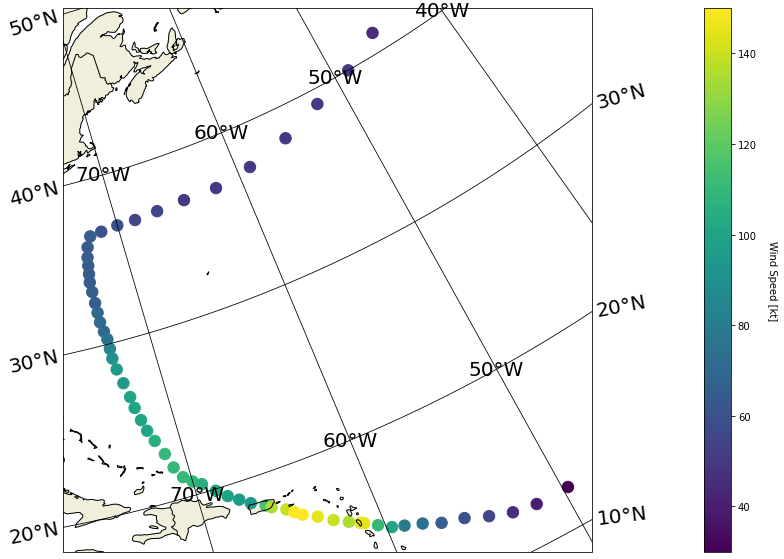

In [4]:
tc_lon = [x['geolocation']['coordinates'][0] for x in tc]
tc_lat = [x['geolocation']['coordinates'][1] for x in tc]
tc_wind = [x['data'][0]['wind'] for x in tc]
simple_map(tc_lon, tc_lat, z=tc_wind, zlabel='Wind Speed [kt]')

## Search and plot colocated Argo data

Next lets see if there were any Argo profiles close by any of the tropical cyclone track points, and add them to our plot (the colocation strategy is indicated in "colo_argo"):

In [5]:
argo = []

for h in tc:
    colo_argo = {
        'center': str(h['geolocation']['coordinates'][0]) + ',' + str(h['geolocation']['coordinates'][1]),
        'radius': 52,
        'startDate': (datetime.strptime(h['timestamp'], "%Y-%m-%dT%H:%M:%S.%fZ") + timedelta(days=-6)).strftime("%Y-%m-%dT%H:%M:%SZ"),
        'endDate': (datetime.strptime(h['timestamp'], "%Y-%m-%dT%H:%M:%S.%fZ") + timedelta(days=6)).strftime("%Y-%m-%dT%H:%M:%SZ"),
        'data': 'temperature,salinity',
        'compression': 'array'
    }
    p = avh.query('argo', options=colo_argo, apikey=API_KEY, apiroot=API_PREFIX)

    if len(p) == 0:
        argo.append(None)
    else:
        print('Profile found adjacent to', h['geolocation']['coordinates'][0], h['geolocation']['coordinates'][1])
        argo.append(p)

Profile found adjacent to -45.6 41.2
Profile found adjacent to -59 37.4
Profile found adjacent to -64.6 37
Profile found adjacent to -73.1 33.9
Profile found adjacent to -72.9 29.7
Profile found adjacent to -72.9 29.1
Profile found adjacent to -70.9 21.9
Profile found adjacent to -70.5 21.2
Profile found adjacent to -70 20.8
Profile found adjacent to -61.3 15.4
Profile found adjacent to -61.1 15.3


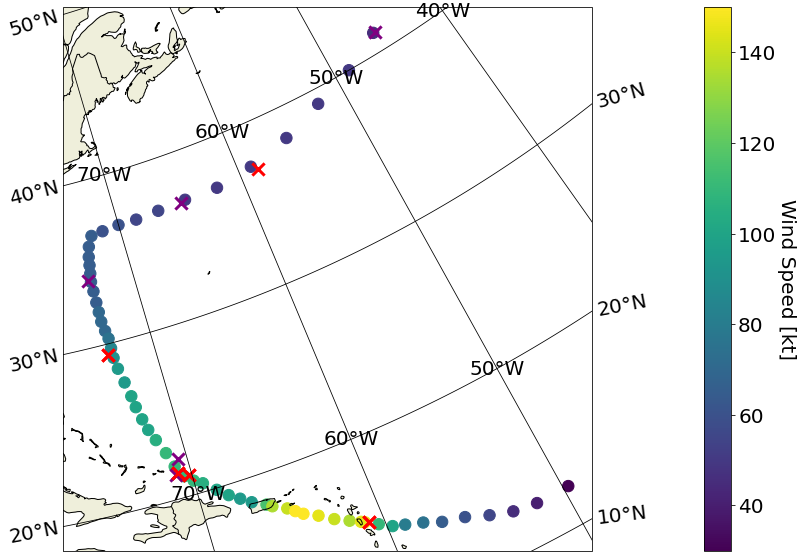

In [6]:
floats = []
colorBefore = 'red'
colorAfter = 'purple'
bracket_points = []
for i, colo in enumerate(argo):
    buddyBefore = False
    buddyAfter = False
    if colo:
        hurrtime = avh.parsetime(tc[i]['timestamp']) 
        for p in colo:
            ptime = avh.parsetime(p['timestamp'])
            buddy={
                "lon": p['geolocation']['coordinates'][0],
                "lat": p['geolocation']['coordinates'][1],
            }
            if ptime < hurrtime:
                buddy['color'] = colorBefore
                buddyBefore = True
            else:
                buddy['color'] = colorAfter
                buddyAfter = True
            floats.append(buddy)
        if buddyBefore and buddyAfter:
            bracket_points.append(i)
simple_map(tc_lon, tc_lat, secondaries=floats, z=tc_wind, zlabel='Wind Speed [kt]')

In the plot above, red X marks profiles collected before the hurricane passed, and purple X marks profiles collected after. Next let's plot the temperatures and salinities found for these profiles, grouping plots by proximate hurricane track point:

In [7]:
def hurrplot(bracket_points, var, maxpress=150, line=False):
    markers = ['.', 'v', 'P', 'X']
    markernames = ['dot', 'triangle', 'plus', 'x']
    fnt_sz = 40
    if var == 'temperature':
        var_units = ', degC'
    elif var == 'salinity':
        var_units = ', psu'
    #fig, axs = plt.subplots(len(bracket_points), figsize=(10,10*len(bracket_points)))
    #n = 0
    for i in bracket_points:
        colo = argo[i]
        hurrtime = avh.parsetime(tc[i]['timestamp'])
        hurrspeed = tc[i]['data'][0]['wind']
        hurrpress = tc[i]['data'][0]['surface_pressure']
        hurrlon = tc[i]['geolocation']['coordinates'][0]
        hurrlat = tc[i]['geolocation']['coordinates'][1]
        annotation = 'Hurricane track longitude: ' + str(hurrlon) + '\nHurricane track latitude: ' + str(hurrlat) + '\nHurricane track timestamp: ' + str(hurrtime) + '\nHurricane wind speed [kt]: ' + str(hurrspeed) + '\nHurricane surface pressure [mb]: ' + str(hurrpress)
        np = 0
        for p in colo:
            ptime = avh.parsetime(p['timestamp'])
            c = colorBefore
            if ptime > hurrtime:
                c = colorAfter
            time2hurricane = str(hurrtime.replace(microsecond=0) - ptime.replace(microsecond=0))
            pressure = [level[p['data_keys'].index('pressure')] for level in p['data']]
            d = [level[p['data_keys'].index(var)] for level in p['data']]
            cutoff = next((i for i,v in enumerate(pressure) if v>maxpress))-1
            psub = pressure[0:cutoff]
            dsub = d[0:cutoff]
            
            if np == 0:
                fig = plt.figure(figsize=(10,10))
                ax  = fig.add_subplot(111)
            
            ax.scatter(dsub, psub, c=[c]*len(psub), marker=markers[np%len(markers)])
            if line:
                ax.plot(dsub, psub, c=c,linewidth=2)
            #ax.set(xlabel=var+var_units, ylabel='Pressure, dbar')
            plt.xlabel(var+var_units, fontsize=fnt_sz)
            plt.ylabel('pressure, dbar', fontsize=fnt_sz)
            ax.tick_params(axis='both', which='major', labelsize=fnt_sz)
            annotation += '\n\nArgo profile ' + p['_id'] + '\nmarker: ' + markernames[np%len(markers)]  + '\nProfile longitude: ' + str(p['geolocation']['coordinates'][0]) + '\nProfile latitude: ' + str(p['geolocation']['coordinates'][1]) + '\nProfile timestamp: ' + str(p['timestamp'])
            np+=1
        ax.invert_yaxis()
        ax.text(ax.get_xlim()[1] + 0.05*(ax.get_xlim()[1]-ax.get_xlim()[0]),0.9*maxpress, annotation, fontsize=fnt_sz)
        #n+=1  

In the plots below, red profiles were collected before the passage of the TC, purple profiles after. We only make the plots for those locations on the TC track where at least one profile is available both before and after (as we are interested in looking at TC induced changes in upper ocean properties). The indices for these points are stored in the variable bracket_points. For now, we only make the plot for the first index stored in the variable bracket_points: to change this and make the plot for all the cases, use the lines in the comments below.

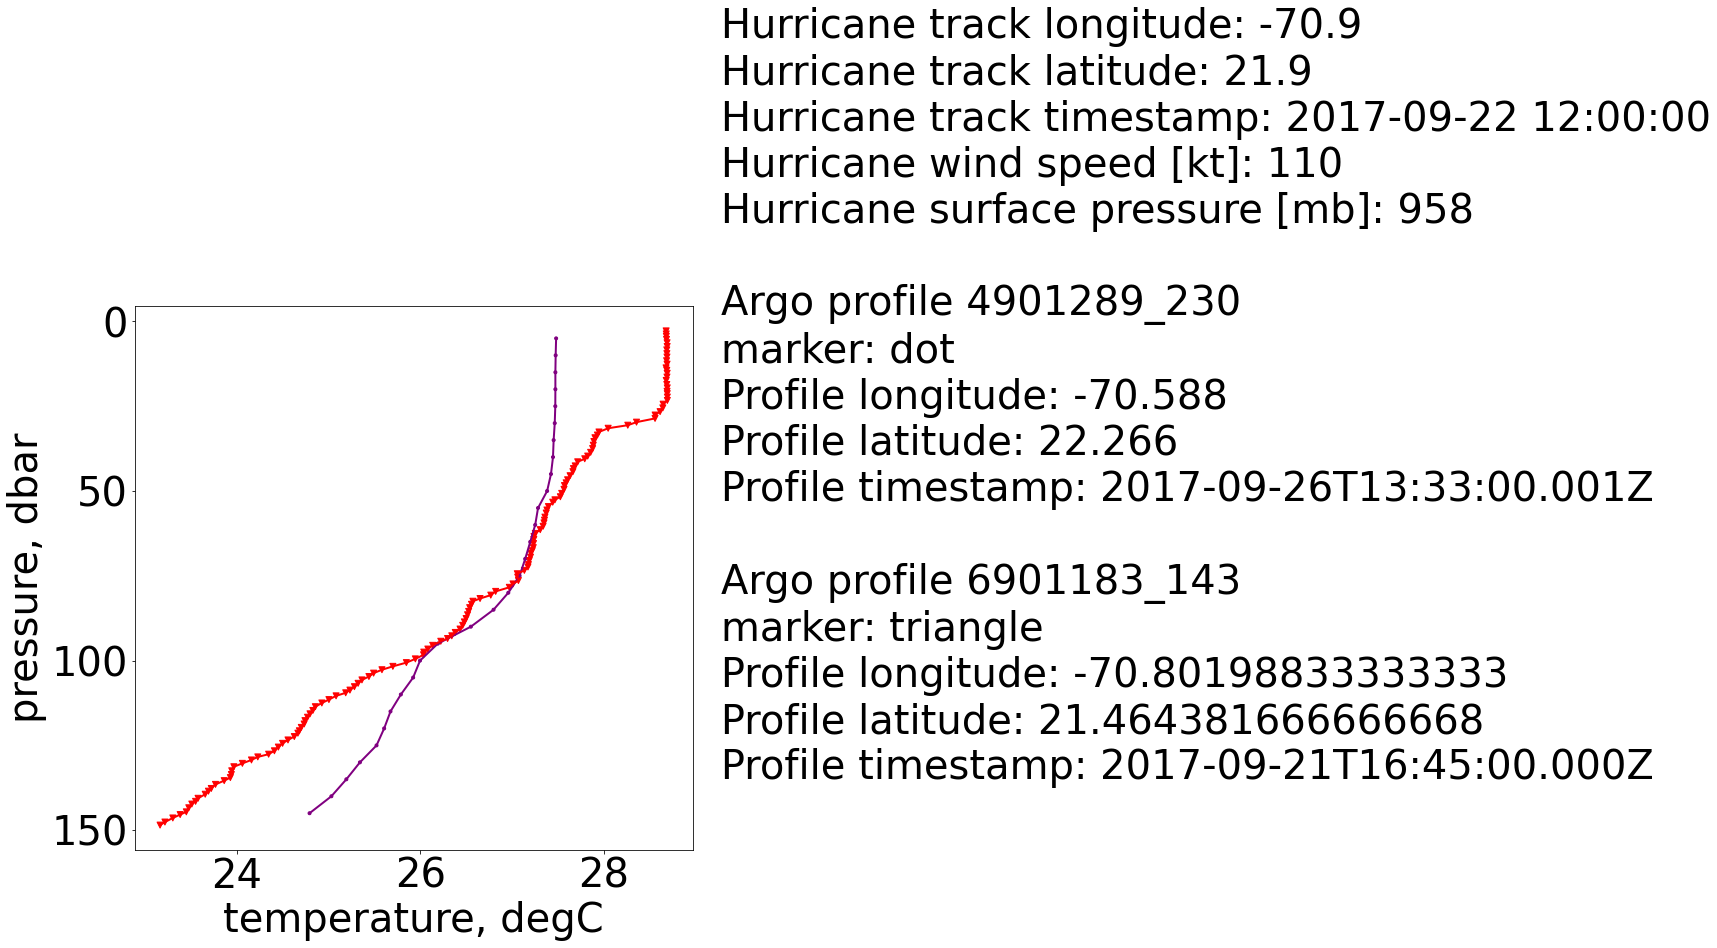

In [8]:
# hurrplot(bracket_points, 'temperature',line=True)
hurrplot([bracket_points[0]], 'temperature',line=True)

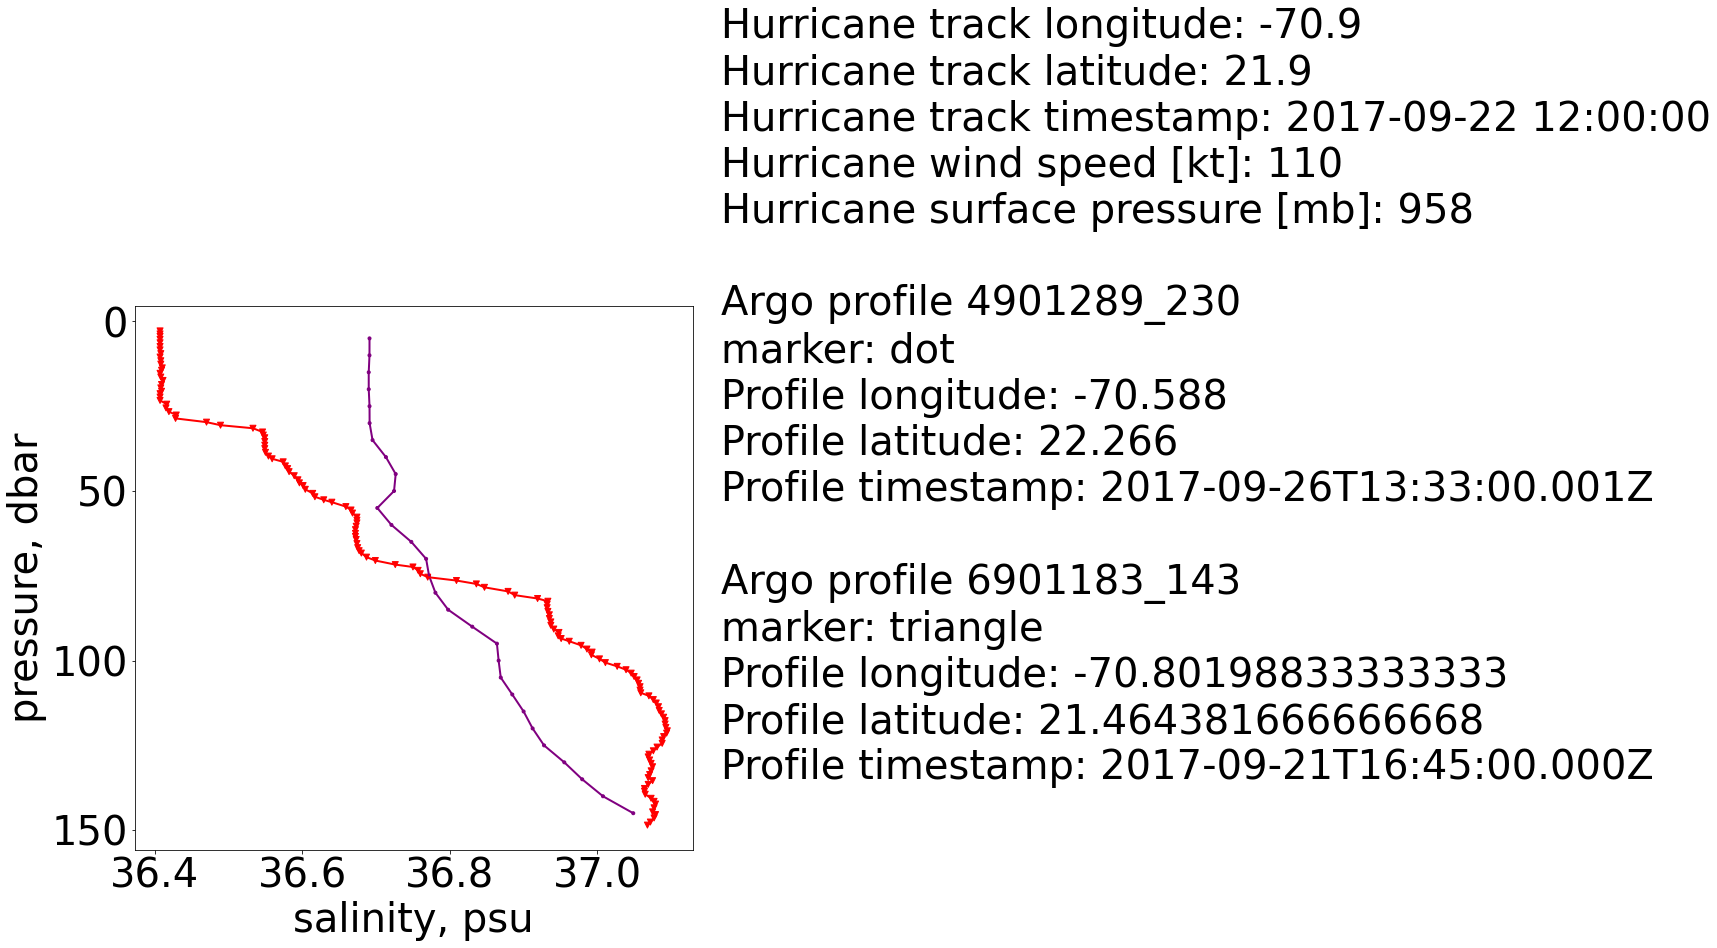

In [9]:
# hurrplot(bracket_points, 'salinity',line=True)
hurrplot([bracket_points[0]], 'salinity',line=True)